In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import train_one_epoch, evaluate_mae, main_train
from inference import infer_seq2point_timeline, infer_seq2point_timeline_all

from refit_dataloader import load_house_csv


SyntaxError: unmatched ')' (sgnNet.py, line 89)

In [ ]:
DATAPATH = r"C:\\Users\\rcper\SGN_NILM\\refit_data\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_ROWS = 800000
WIN_LEN = 512
STRIDE = 16
BATCH_SIZE = 16
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 10
MIN_DELTA = 0.0
RESAMPLE_RULE = "30s"

In [ ]:
mains, target, ts = load_house_csv(DATAPATH, appliance_col=APPLIANCE_COL, max_rows = MAX_ROWS,
                                   resample_rule=RESAMPLE_RULE)
print(f"Loaded {len(mains)} samples for House 2")

Loaded 800000 samples for House 2


In [ ]:
n = len(mains)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val, target_val = mains[train_end:val_end], target[train_end:val_end]
mains_test, target_test   = mains[val_end:], target[val_end:]

train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val, target_val, win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test, target_test, win_len=WIN_LEN, stride=STRIDE, train=False)


Epoch 001 | Train Loss: 0.4146 | Val Loss: 0.7439 | Val MAE (W): 21.10
Epoch 002 | Train Loss: 0.2781 | Val Loss: 0.6520 | Val MAE (W): 19.92
Epoch 003 | Train Loss: 0.2808 | Val Loss: 0.6330 | Val MAE (W): 19.94
Epoch 004 | Train Loss: 0.2249 | Val Loss: 0.5501 | Val MAE (W): 19.95
Epoch 005 | Train Loss: 0.2073 | Val Loss: 0.4583 | Val MAE (W): 19.90
Epoch 006 | Train Loss: 0.2021 | Val Loss: 0.4981 | Val MAE (W): 19.94
Epoch 007 | Train Loss: 0.1989 | Val Loss: 0.5365 | Val MAE (W): 19.78
Epoch 008 | Train Loss: 0.1936 | Val Loss: 0.5416 | Val MAE (W): 19.22
Epoch 009 | Train Loss: 0.1793 | Val Loss: 0.4229 | Val MAE (W): 18.35
Epoch 010 | Train Loss: 0.1483 | Val Loss: 0.4027 | Val MAE (W): 18.03
Epoch 011 | Train Loss: 0.1552 | Val Loss: 0.4240 | Val MAE (W): 18.32
Epoch 012 | Train Loss: 0.1306 | Val Loss: 0.3202 | Val MAE (W): 14.48
Epoch 013 | Train Loss: 0.0971 | Val Loss: 0.4846 | Val MAE (W): 15.01
Epoch 014 | Train Loss: 0.1216 | Val Loss: 0.3470 | Val MAE (W): 14.49
Epoch 

c:\Users\rcper\SGN_NILM\training.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


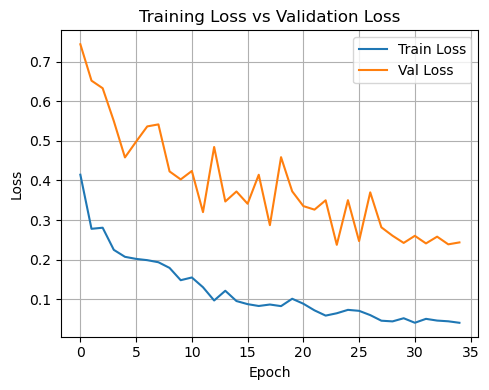

In [ ]:
results = main_train(
    mains_train, target_train,
    mains_val, target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("sgn_best.pt", map_location=device, weights_only=True)
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

power_w, reg_w, cls_p = infer_seq2point_timeline_all(model, mains_test, stats, device)
y_true = target_test  # watts


In [ ]:
def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

mae_w = np.mean(np.abs(power_w - y_true))
energy_true = y_true.sum()
energy_pred = power_w.sum()
sae = np.abs(energy_pred - energy_true) / (energy_true + 1e-6)
smape_val = smape(y_true, power_w)

print(f"House2 {APPLIANCE_COL} | Test MAE (W): {mae_w:.2f}")
print(f"SAE (energy rel. error): {sae:.4f}")
print(f"sMAPE (%): {smape_val:.2f}")


House2 Appliance2 | Test MAE (W): 7.70
SAE (energy rel. error): 0.2209
sMAPE (%): 96.50


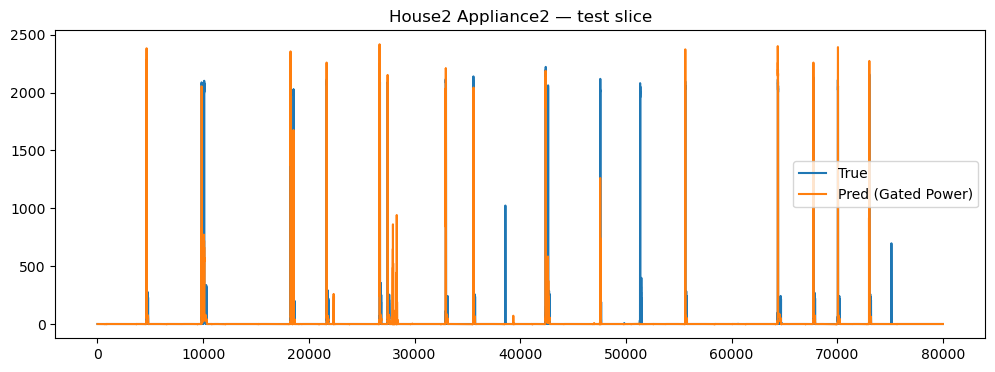

In [ ]:
N = min(80000, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_w[:N], label="Pred (Gated Power)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice")
plt.show()


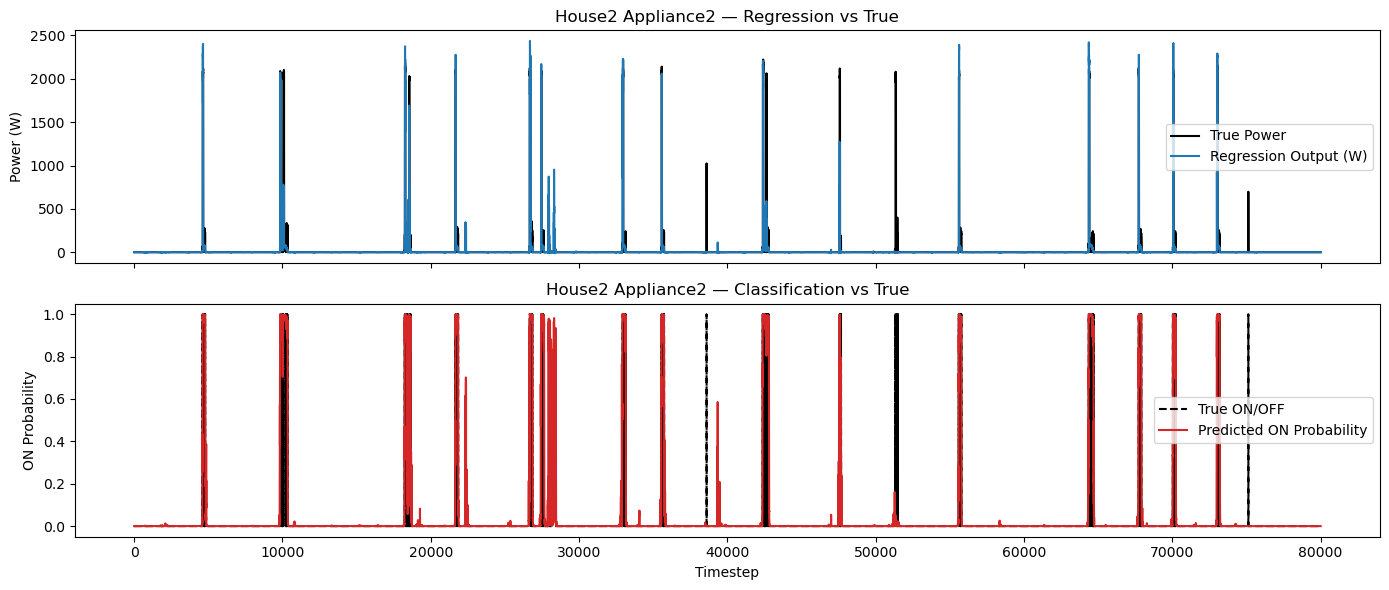

In [ ]:
N = min(80000, len(y_true))


on_threshold = 20.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)


ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()


ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(cls_p[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()

plt.tight_layout()
plt.show()